# S2S RNN to predict next state

We aim to predict the next steps on time series

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [13]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [14]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [15]:
import import_ipynb

import Process_Training_Data

from Process_Training_Data import norm
from Process_Training_Data import class_to_action

### Get the data
First Import it using pandas

In [16]:
dataset_short = Process_Training_Data.get_data("./data/fromStateToAction_df (28) last.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data.normalize_data(dataset_short,action_vector)

N_STEPS = 3
dataset2 = Process_Training_Data.post_padding(normed_dataset,N_STEPS)

In [17]:
training_size = len(dataset_short)
training_size 

4673

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [18]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [19]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [20]:
x_train_single_sequential[0]

array([[ 1.59717363, -1.70102178,  0.6942984 ,  1.1497174 , -0.15136753,
        -0.27057772, -0.06981   ,  0.        ],
       [ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035, -0.01745   ,  0.        ],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792, -0.05236   ,  0.        ]])

In [21]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (3, 8)


In [22]:
y_train_single_sequential[0]

array([[-0.01745,  0.     ],
       [-0.05236,  0.     ],
       [-0.05236,  0.     ]])

In [23]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [24]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True,input_shape=(None, 8)))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mse','mae'])

### Inspect the model

In [25]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 11)          880       
_________________________________________________________________
dense (Dense)                (None, None, 2)           24        
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [26]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 233.65 steps, validate for 50 steps
Epoch 1/20
234/233 [==============================] - 9s 37ms/step - loss: 0.0460 - mse: 0.0045 - mae: 0.0460 - val_loss: 0.0367 - val_mse: 0.0027 - val_mae: 0.0367
Epoch 2/20
234/233 [==============================] - 1s 6ms/step - loss: 0.0328 - mse: 0.0023 - mae: 0.0329 - val_loss: 0.0318 - val_mse: 0.0022 - val_mae: 0.0318
Epoch 3/20
234/233 [==============================] - 1s 6ms/step - loss: 0.0301 - mse: 0.0020 - mae: 0.0301 - val_loss: 0.0293 - val_mse: 0.0020 - val_mae: 0.0293
Epoch 4/20
234/233 [==============================] - 2s 7ms/step - loss: 0.0283 - mse: 0.0018 - mae: 0.0283 - val_loss: 0.0276 - val_mse: 0.0017 - val_mae: 0.0276
Epoch 5/20
234/233 [==============================] - 1s 6ms/step - loss: 0.0272 - mse: 0.0017 - mae: 0.0272 - val_loss: 0.0276 - val_mse: 0.0017 - val_mae: 0.0276
Epoch 6/20
234/233 [==============================] - 2s 6ms/step - loss: 0.0260 - mse: 0.0016 - mae: 0.0260 - val_loss: 0.0253 - val

Compute the accuracy

In [34]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [39]:
def closest_category(X, pred):
    tree = sklearn.neighbors.KDTree(X, leaf_size=2)
    dist, ind = tree.query(pred, k=1)
    return ind

In [40]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

0.45775402


In [41]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

935/935 - 0s - loss: 0.0194 - mse: 0.0011 - mae: 0.0194


Visualize the model's training progress.

In [42]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

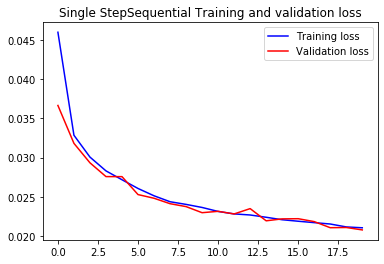

In [32]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [43]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0188,  mae:0.0188,  mse:0.0010,  val_loss:0.0188,  val_mae:0.0187,  val_mse:0.0010,  
....................

In [44]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.4748663


In [38]:
single_step_sequential_model.save('./data/single_step_sequential_model.h5') 